# Additional forces
REBOUND is a gravitational N-body integrator. But you can also use it to integrate systems with additional, non-gravitational forces.

This tutorial gives you a very quick overview of how that works. 

**Stark problem**

We'll start be adding two particles, the Sun and an Earth-like planet to REBOUND.

In [1]:
import rebound
sim = rebound.Simulation()
sim.integrator = "whfast"
sim.add(m=1.)
sim.add(m=1e-6,a=1.)
sim.move_to_com()  # Moves to the center of momentum frame

We could integrate this system and the planet would go around the star at a fixed orbit with $a=1$ forever. Let's add an additional constant force that acting on the planet and is pointing in one direction $F_x = m\cdot c$, where $m$ is the planet's mass and $c$ a constant. This is called the Stark problem. In python we can describe this with the following function

In [2]:
ps = sim.particles
c = 0.01
def starkForce(reb_sim):
    ps[1].ax += c

Next, we need to tell REBOUND about this function. 

In [3]:
sim.additional_forces = starkForce

Now we can just integrate as usual. Let's keep track of the eccentricity as we integrate as it will change due to the additional force.

In [4]:
import numpy as np
Nout = 1000
es = np.zeros(Nout)
times = np.linspace(0.,100.*2.*np.pi,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    es[i] = sim.calculate_orbits()[0].e 

And let's plot the result.

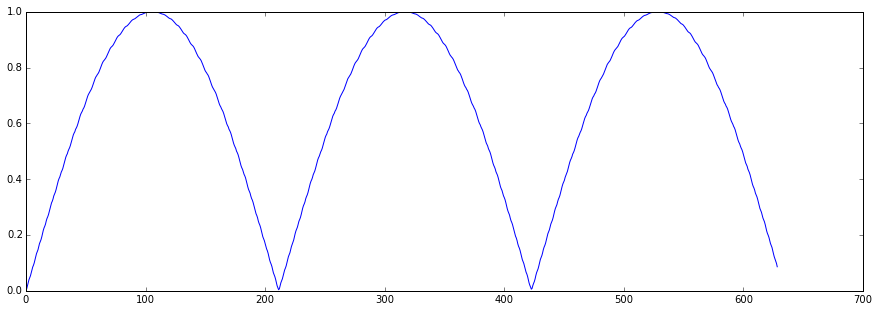

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
plt.plot(times, es);

You can see that the eccentricity is oscillating between 0 and almost 1. 

**Non-conservative forces**

The previous example assumed a conservative force, i.e. we could describe it as a potential as it is velocity independent. Now, let's assume we have a velocity dependent force. This could be a migration force in a protoplanetary disk or PR drag. We'll start from scratch and add the same two particles as before.

In [ ]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.add(m=1.)
sim.add(m=1e-6,a=1.)
sim.move_to_com()  # Moves to the center of momentum frame

But we change the additional force to be

In [ ]:
ps = sim.particles
tau = 1000.
def migrationForce(reb_sim):
    ps[1].ax -= ps[1].vx/tau
    ps[1].ay -= ps[1].vy/tau
    ps[1].az -= ps[1].vz/tau

We need to let REBOUND know that our force is velocity dependent. Otherwise, REBOUND will not update the velocities of the particles. 

In [ ]:
sim.additional_forces = migrationForce
sim.force_is_velocity_dependent = 1

Now, we integrate as before. But this time we keep track of the semi-major axis instead of the eccentricity.

In [ ]:
Nout = 1000
a_s = np.zeros(Nout)
times = np.linspace(0.,100.*2.*np.pi,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    a_s[i] = sim.calculate_orbits()[0].a 
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_xlabel("time")
ax.set_ylabel("semi-major axis")
plt.plot(times, a_s);

The semi-major axis decaus exponentially on a timescale `tau`.

In the above example, REBOUND is calling a python function at every timestep. This can be slow. Note that you can also set `rebound.additional_forces` to a c function pointer. This let's you speed up the simulation significantly. However, you need to write you own c function/library that knows how to calculate the forces. Or, you use Dan Tamayo's new migration library (in preparation).